In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

### Cargo el dataset y proporciono los tipos de datos cada columna.

In [2]:

# Leer el archivo, asumiendo que est√° separado por espacios
# Leer el archivo en formato de ancho fijo
df = pd.read_fwf('registro_temperatura365d_smn.txt',
                encoding='latin1',
                skiprows=[1])

# Eliminar filas donde 'NOMBRE' sea igual a los guiones
df = df[df['NOMBRE'] != '----------------------------------------']

# Convertir la columna FECHA a tipo datetime.
# En el dataset, la fecha est√° en formato DDMMYYYY, por ejemplo, "26032025" es 26/03/2025.
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%d%m%Y', errors='coerce')

# Convertir TMAX y TMIN a n√∫meros (float), forzando la conversi√≥n y convirtiendo en NaN los que no se puedan convertir.
df['TMAX'] = pd.to_numeric(df['TMAX'], errors='coerce')
df['TMIN'] = pd.to_numeric(df['TMIN'], errors='coerce')

# Convertir NOMBRE a string, aunque generalmente ya se interpreta como tal.
df['NOMBRE'] = df['NOMBRE'].astype(str)
print(f"Cantidad de estaciones √∫nicas: {df['NOMBRE'].nunique()}")
#print(sorted(df['NOMBRE'].unique()))





Cantidad de estaciones √∫nicas: 118


In [3]:
# Verificaci√≥n: mostrar la informaci√≥n del dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 42915 entries, 1 to 42915
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   FECHA   42915 non-null  datetime64[ns]
 1   TMAX    38377 non-null  float64       
 2   TMIN    42294 non-null  float64       
 3   NOMBRE  42915 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.6+ MB
None


### Ver el resumen de datos faltantes

In [4]:
# Me proporciona la cantidad de nulos (NaN) por columna.
df.isna().sum()

FECHA        0
TMAX      4538
TMIN       621
NOMBRE       0
dtype: int64

### Localizar las estaciones con valores faltantes en TMAX.

In [5]:
# Filtramos las filas donde TMAX es nulo
df_missing = df[df['TMAX'].isna()]

# Agrupamos por estaci√≥n y contamos cu√°ntos faltantes
missing_counts = df_missing.groupby('NOMBRE').size().reset_index(name='count_missing')

# Mostramos de mayor a menor
missing_counts = missing_counts.sort_values('count_missing', ascending=False)

print(missing_counts)


                              NOMBRE  count_missing
5                      CHAMICAL AERO            365
28                   RIO CUARTO AERO            365
11  ESCUELA DE AVIACION MILITAR AERO            365
9                       DOLORES AERO            351
29            SAN ANTONIO OESTE AERO            347
17               MARIANO MORENO AERO            339
38                       VIEDMA AERO            327
32                     TARTAGAL AERO            322
19              MENDOZA OBSERVATORIO            302
4                         CERES AERO            273
31        SANTA ROSA DE CONLARA AERO            177
22                MONTE CASEROS AERO            175
35                      USHUAIA AERO            137
24                       PARANA AERO            116
20                        MERLO AERO             96
26                PERITO MORENO AERO             84
18                      MENDOZA AERO             84
0                  BAHIA BLANCA AERO             74
23          

 ### Opcional: Ver cu√°ntos datos totales distinto de valores faltantes reporta cada estaci√≥n

In [6]:
total_by_station = df.groupby('NOMBRE').size().reset_index(name='count_total')
total_by_station.sort_values('count_total', ascending=False, inplace=True)

print(total_by_station)


                 NOMBRE  count_total
0       AEROPARQUE AERO          365
74         POSADAS AERO          365
86         ROSARIO AERO          365
85            RIVADAVIA          365
84      RIO GRANDE B.A.          365
..                  ...          ...
14   CAMPO DE MAYO AERO          362
64                OBERA          341
40               JACHAL          340
112           VICTORICA          326
20       CHILECITO AERO          301

[118 rows x 2 columns]


In [7]:

# Supongamos que ya cargaste el dataframe 'df'
# Por ejemplo:
# df = pd.read_csv('registro_temperatura365d_smn.txt', delim_whitespace=True, names=['FECHA', 'TMAX', 'TMIN', 'NOMBRE'], header=0)

# 1. Calcular el n√∫mero total de registros por estaci√≥n
total_por_estacion = df.groupby('NOMBRE').size().reset_index(name='total_registros')

# 2. Calcular el n√∫mero de registros con TMAX faltante por estaci√≥n
faltantes_por_estacion = df[df['TMAX'].isna()].groupby('NOMBRE').size().reset_index(name='cantidad_valores_faltantes')

# 3. Unir ambos resultados (se usa 'left' para incluir todas las estaciones)
estaciones_faltantes = pd.merge(total_por_estacion, faltantes_por_estacion, on='NOMBRE', how='left')
estaciones_faltantes['cantidad_valores_faltantes'] = estaciones_faltantes['cantidad_valores_faltantes'].fillna(0)  # Reemplazar NaN por 0

# 4. Calcular el porcentaje de datos faltantes
estaciones_faltantes['porc_faltantes'] = (estaciones_faltantes['cantidad_valores_faltantes'] / estaciones_faltantes['total_registros']) * 100

# 5. Ordenar el resultado de mayor a menor porcentaje de faltantes
estaciones_faltantes = estaciones_faltantes.sort_values('porc_faltantes', ascending=False)
#estaciones_faltantes = estaciones_faltantes.set_index('NOMBRE')
print(estaciones_faltantes)


                               NOMBRE  total_registros  \
31   ESCUELA DE AVIACION MILITAR AERO              365   
17                      CHAMICAL AERO              365   
82                    RIO CUARTO AERO              365   
27                       DOLORES AERO              365   
88             SAN ANTONIO OESTE AERO              365   
..                                ...              ...   
45             LA QUIACA OBSERVATORIO              365   
44                      LA PLATA AERO              365   
43                         JUNIN AERO              365   
38                        IGUAZU AERO              365   
117               VILLA REYNOLDS AERO              365   

     cantidad_valores_faltantes  porc_faltantes  
31                        365.0      100.000000  
17                        365.0      100.000000  
82                        365.0      100.000000  
27                        351.0       96.164384  
88                        347.0       95.068493  
.. 

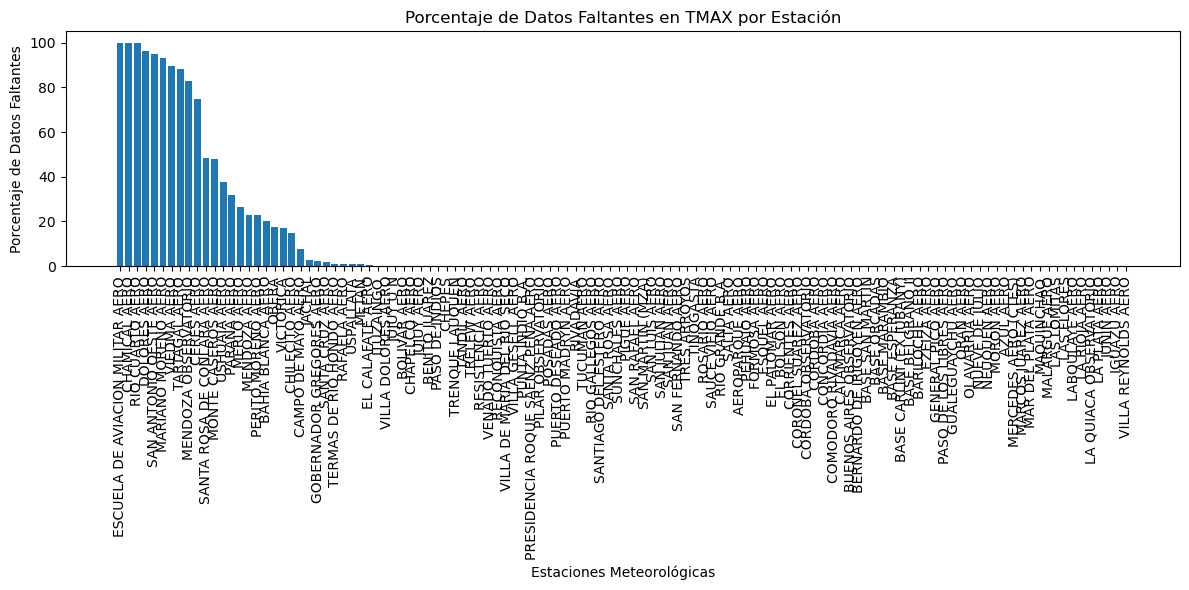

In [8]:
# Convertir el nombre de la estaci√≥n en √≠ndice para facilitar la visualizaci√≥n
estaciones_faltantes = estaciones_faltantes.set_index('NOMBRE')

# Crear el gr√°fico de barras
plt.figure(figsize=(12, 6))
plt.bar(estaciones_faltantes.index, estaciones_faltantes['porc_faltantes'])
plt.xlabel('Estaciones Meteorol√≥gicas')
plt.ylabel('Porcentaje de Datos Faltantes')
plt.title('Porcentaje de Datos Faltantes en TMAX por Estaci√≥n')
plt.xticks(rotation=90)  # Gira los nombres para mejor visualizaci√≥n
plt.tight_layout()  # Ajusta la distribuci√≥n para que no se solapen elementos
plt.show()


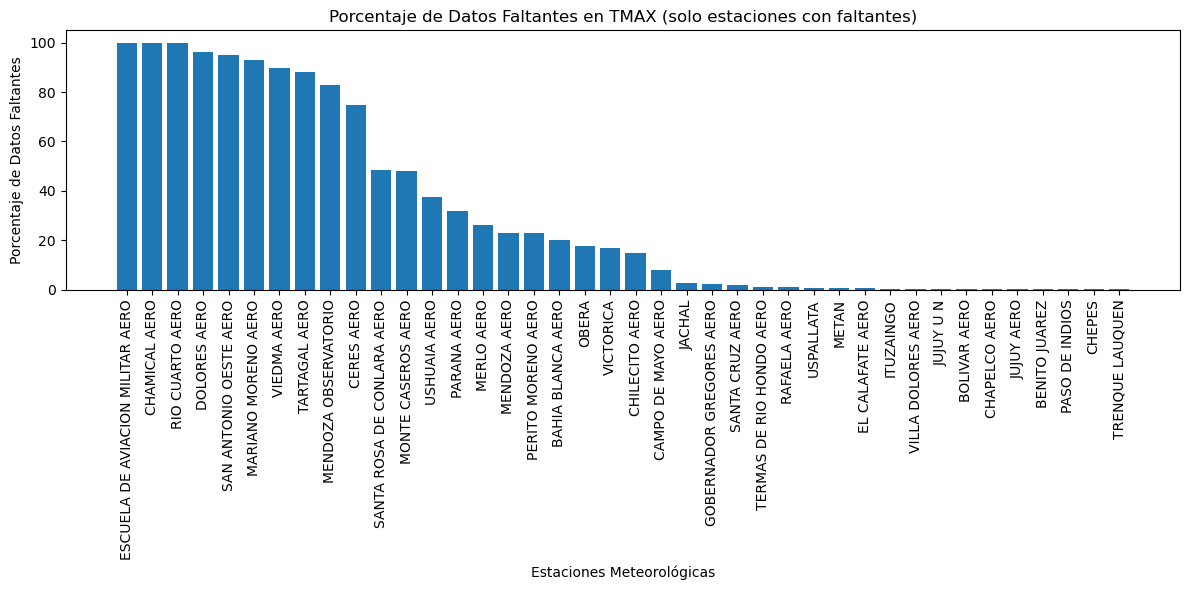

In [9]:
# Filtrar solo las estaciones que tienen alg√∫n dato faltante en TMAX
estaciones_con_faltantes = estaciones_faltantes[estaciones_faltantes['cantidad_valores_faltantes'] > 0]
#print(estaciones_con_faltantes.columns)
# Si la columna "NOMBRE" no est√° en las columnas (porque ya es el √≠ndice), aseg√∫rate de que el √≠ndice tenga nombre:
if 'NOMBRE' not in estaciones_con_faltantes.columns:
    estaciones_con_faltantes.index.name = 'NOMBRE'

# Crear el gr√°fico de barras
plt.figure(figsize=(12, 6))
plt.bar(estaciones_con_faltantes.index, estaciones_con_faltantes['porc_faltantes'])
plt.xlabel('Estaciones Meteorol√≥gicas')
plt.ylabel('Porcentaje de Datos Faltantes')
plt.title('Porcentaje de Datos Faltantes en TMAX (solo estaciones con faltantes)')
plt.xticks(rotation=90)  # Gira los nombres para mejor visualizaci√≥n
plt.tight_layout()
plt.show()

In [10]:
umbral = 50

# Si "NOMBRE" no es una columna, restablecemos el √≠ndice:
if 'NOMBRE' not in estaciones_faltantes.columns:
    estaciones_faltantes = estaciones_faltantes.reset_index()

# Filtrar las estaciones v√°lidas seg√∫n el umbral (menos del 50% de datos faltantes)
estaciones_validas = estaciones_faltantes[estaciones_faltantes['porc_faltantes'] < umbral]['NOMBRE']

# Seleccionar del dataset original solo las filas correspondientes a las estaciones v√°lidas
df_valido = df[df['NOMBRE'].isin(estaciones_validas)].copy()

print("Estaciones v√°lidas seg√∫n el criterio:")
print(estaciones_validas)

Estaciones v√°lidas seg√∫n el criterio:
10     SANTA ROSA DE CONLARA AERO
11             MONTE CASEROS AERO
12                   USHUAIA AERO
13                    PARANA AERO
14                     MERLO AERO
                  ...            
113        LA QUIACA OBSERVATORIO
114                 LA PLATA AERO
115                    JUNIN AERO
116                   IGUAZU AERO
117           VILLA REYNOLDS AERO
Name: NOMBRE, Length: 108, dtype: object


### Pod√©s establecer un umbral que te sirva como "criterio m√≠nimo" de datos disponibles. Por ejemplo, si decid√≠s que una estaci√≥n debe tener al menos el 50‚ÄØ% de sus datos registrados para considerarla confiable, entonces:

### Si el porcentaje de datos faltantes es mayor al 50‚ÄØ% (es decir, la estaci√≥n tiene menos del 50‚ÄØ% de datos reales), se recomienda excluir esa estaci√≥n del an√°lisis o tratarla de forma especial.

### Si el porcentaje es menor o igual al 50‚ÄØ%, la estaci√≥n cuenta con suficiente informaci√≥n para intentar imputar los datos faltantes de manera m√°s confiable.

### A modo de ejemplo, si el DataFrame "estaciones" tiene una columna "porcentaje" que indica el porcentaje de faltantes por estaci√≥n, pod√©s filtrar las estaciones v√°lidas as√≠:

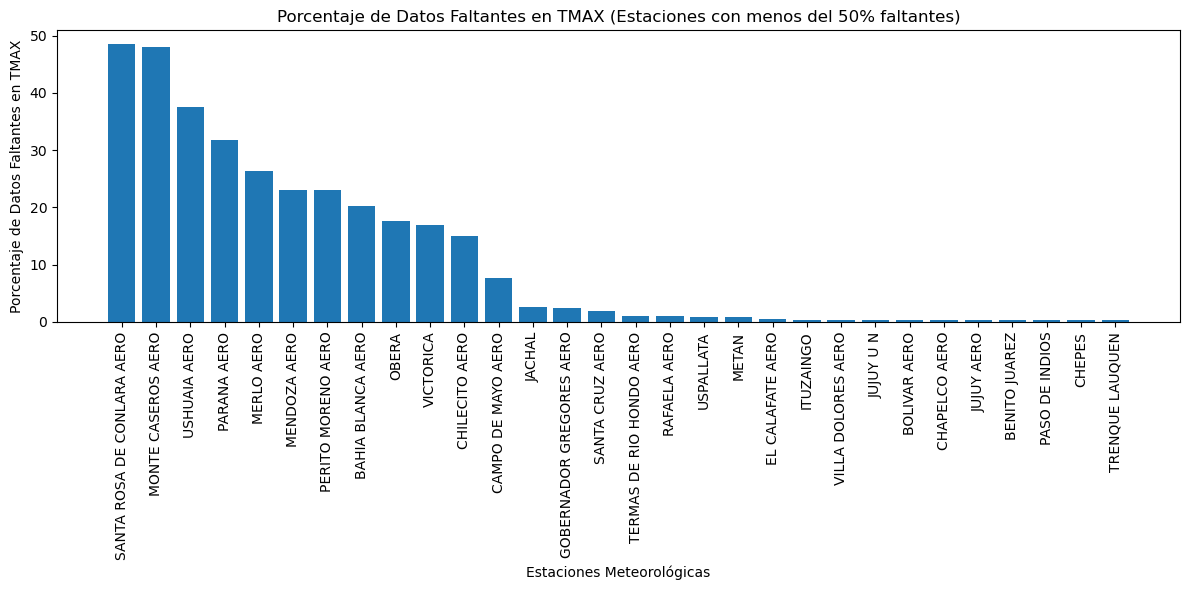

In [11]:
# Definir el umbral de faltantes (por ejemplo, 75%)
umbral = 50

# Asegurarse de que "NOMBRE" est√© en el DataFrame
if 'NOMBRE' not in estaciones_faltantes.columns:
    estaciones_faltantes = estaciones_faltantes.reset_index()

# Filtrar las estaciones v√°lidas seg√∫n el umbral
estaciones_validas_df = estaciones_faltantes[(estaciones_faltantes['porc_faltantes'] < umbral) &
    (estaciones_faltantes['cantidad_valores_faltantes'] > 0)]

# Graficar el histograma (barras)
plt.figure(figsize=(12, 6))
plt.bar(estaciones_validas_df['NOMBRE'], estaciones_validas_df['porc_faltantes'])
plt.xlabel('Estaciones Meteorol√≥gicas')
plt.ylabel('Porcentaje de Datos Faltantes en TMAX')
plt.title(f'Porcentaje de Datos Faltantes en TMAX (Estaciones con menos del {umbral}% faltantes)')
plt.xticks(rotation=90)  # Gira los nombres para mejorar la legibilidad
plt.tight_layout()
plt.show()


In [12]:
total_estaciones = estaciones_faltantes['NOMBRE'].nunique()
validas = estaciones_validas_df['NOMBRE'].nunique()
excluidas = total_estaciones - validas
print(f"üìå Estaciones que no superan el 50% de datos faltantes y no tienen datos faltantes en TMAX: {excluidas}")
estaciones_fuera = estaciones_faltantes[
    estaciones_faltantes['porc_faltantes'] >= umbral
]['NOMBRE'].unique()
print("total de estaciones")
print(total_estaciones)
print(f"üìå Estaciones v√°lidas,que no superan el 50% de datos faltantes en TMAX y que tienen datos faltantes: {validas}")

estaciones_fuera
#estaciones_con_faltantes



üìå Estaciones que no superan el 50% de datos faltantes y no tienen datos faltantes en TMAX: 88
total de estaciones
118
üìå Estaciones v√°lidas,que no superan el 50% de datos faltantes en TMAX y que tienen datos faltantes: 30


array(['ESCUELA DE AVIACION MILITAR AERO', 'CHAMICAL AERO',
       'RIO CUARTO AERO', 'DOLORES AERO', 'SAN ANTONIO OESTE AERO',
       'MARIANO MORENO AERO', 'VIEDMA AERO', 'TARTAGAL AERO',
       'MENDOZA OBSERVATORIO', 'CERES AERO'], dtype=object)

In [13]:
# Agrupar por estaci√≥n para quedarte con un solo valor por estaci√≥n
estaciones_agru = estaciones_faltantes.groupby('NOMBRE')['porc_faltantes'].max().reset_index()

# Estaciones excluidas (porcentaje de faltantes >= umbral)
estaciones_fuera = estaciones_agru[estaciones_agru['porc_faltantes'] >= umbral]

# Estaciones v√°lidas
estaciones_validas = estaciones_agru[estaciones_agru['porc_faltantes'] < umbral]

# C√°lculos
total = estaciones_agru['NOMBRE'].nunique()
excluidas = estaciones_fuera['NOMBRE'].nunique()
validas = estaciones_validas['NOMBRE'].nunique()

print(f"üìä Total de estaciones: {total}")
print(f"‚úÖ Estaciones v√°lidas (menos del {umbral}% de datos faltantes): {validas}")
print(f"‚ùå Estaciones excluidas por superar el umbral: {excluidas}")
print("üîç Lista de estaciones excluidas:")
print(estaciones_fuera['NOMBRE'].tolist())


üìä Total de estaciones: 118
‚úÖ Estaciones v√°lidas (menos del 50% de datos faltantes): 108
‚ùå Estaciones excluidas por superar el umbral: 10
üîç Lista de estaciones excluidas:
['CERES AERO', 'CHAMICAL AERO', 'DOLORES AERO', 'ESCUELA DE AVIACION MILITAR AERO', 'MARIANO MORENO AERO', 'MENDOZA OBSERVATORIO', 'RIO CUARTO AERO', 'SAN ANTONIO OESTE AERO', 'TARTAGAL AERO', 'VIEDMA AERO']


## Ejemplo imputar por grupo (Estaci√≥n + Mes) Utilizando el algoritmo KNN

In [14]:


# Ejemplo de dataset
data = {
    'FECHA': ['01012025', '01012025', '02012025', '02012025', 
              '03012025', '03012025', '01022025', '01022025'],
    'TMAX': [30.0, np.nan, 32.0, 31.0, np.nan, 29.0, 28.0, np.nan],
    'TMIN': [15.0, 14.0, np.nan, 16.0, 13.0, np.nan, 12.0, 11.0],
    'NOMBRE': ['EstacionA', 'EstacionA', 'EstacionA', 'EstacionA', 
               'EstacionB', 'EstacionB', 'EstacionB', 'EstacionB']
}
df_sample = pd.DataFrame(data)

# Convertir FECHA a datetime y extraer el mes
df_sample['FECHA'] = pd.to_datetime(df_sample['FECHA'], format='%d%m%Y')
df_sample['mes'] = df_sample['FECHA'].dt.month

print (df_sample)
# Funci√≥n que aplica KNN imputation en un grupo (por estaci√≥n y mes)
def impute_group(grupo):
    imputer = KNNImputer(n_neighbors=2)  # Ajust√° n_neighbors seg√∫n convenga
    columnas = ['TMAX', 'TMIN']
    grupo_imputado = grupo.copy()
    grupo_imputado[columnas] = imputer.fit_transform(grupo[columnas])
    return grupo_imputado

# Agrupar por estaci√≥n y mes y aplicar la funci√≥n de imputaci√≥n
df_imputed = df_sample.groupby(['NOMBRE', 'mes']).apply(impute_group).reset_index(drop=True)

print("Imputaci√≥n por grupo:")
print(df_imputed)


       FECHA  TMAX  TMIN     NOMBRE  mes
0 2025-01-01  30.0  15.0  EstacionA    1
1 2025-01-01   NaN  14.0  EstacionA    1
2 2025-01-02  32.0   NaN  EstacionA    1
3 2025-01-02  31.0  16.0  EstacionA    1
4 2025-01-03   NaN  13.0  EstacionB    1
5 2025-01-03  29.0   NaN  EstacionB    1
6 2025-02-01  28.0  12.0  EstacionB    2
7 2025-02-01   NaN  11.0  EstacionB    2
Imputaci√≥n por grupo:
       FECHA  TMAX  TMIN     NOMBRE  mes
0 2025-01-01  30.0  15.0  EstacionA    1
1 2025-01-01  30.5  14.0  EstacionA    1
2 2025-01-02  32.0  15.5  EstacionA    1
3 2025-01-02  31.0  16.0  EstacionA    1
4 2025-01-03  29.0  13.0  EstacionB    1
5 2025-01-03  29.0  13.0  EstacionB    1
6 2025-02-01  28.0  12.0  EstacionB    2
7 2025-02-01  28.0  11.0  EstacionB    2


/tmp/ipykernel_27523/2936429328.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_imputed = df_sample.groupby(['NOMBRE', 'mes']).apply(impute_group).reset_index(drop=True)


### Fin del ejemplo.

### En la siguente celda reci√©n obtengo del dataset original otro con las estaciones que no superan el 50% de datos faltantes en la columna TMA.

In [15]:
# Seleccionar del dataset original solo las filas correspondientes a las estaciones v√°lidas
#df_valido = df[df['NOMBRE'].isin(estaciones_validas)].copy()
df_completo = df_valido.copy() 
df_completo
df_completo.columns
cantidad_de_estaciones= df_completo['NOMBRE'].nunique()
print ("cantidad de estaiones luego de aplicar el criterio del 50 % umbral:", cantidad_de_estaciones )

cantidad de estaiones luego de aplicar el criterio del 50 % umbral: 108


In [16]:
df_completo['mes'] = df_completo['FECHA'].dt.month
df_completo

FECHA  TMAX  TMIN                       NOMBRE  mes
1     2025-04-06  21.8  13.8              AEROPARQUE AERO    4
2     2025-04-06  21.6   6.1                    AZUL AERO    4
3     2025-04-06  22.5   7.9            BAHIA BLANCA AERO    4
4     2025-04-06  22.4  -0.8               BARILOCHE AERO    4
5     2025-04-06 -10.3 -20.7             BASE BELGRANO II    4
...          ...   ...   ...                          ...  ...
42910 2024-04-07   NaN   NaN                    VICTORICA    4
42912 2024-04-07  23.0  15.1  VILLA DE MARIA DEL RIO SECO    4
42913 2024-04-07  29.5  18.4           VILLA DOLORES AERO    4
42914 2024-04-07  25.6  13.5            VILLA GESELL AERO    4
42915 2024-04-07  32.0   8.1          VILLA REYNOLDS AERO    4

[39265 rows x 5 columns]

In [17]:
# Ver cantidad total de faltantes por columna
faltantes = df_completo[['TMAX', 'TMIN']].isna().sum()
print("Cantidad de datos faltantes antes de realizar la priemra imputaci√≥n:\n", faltantes)



Cantidad de datos faltantes antes de realizar la priemra imputaci√≥n:
 TMAX    1182
TMIN     614
dtype: int64


### El bloque de c√≥digo siguiente imputa con el algoritmno KNN al data frame 'df_completo' que contiene estaciones metereologica con menos del 50% de datos faltantes. 

In [18]:
# Asegurarte de tener la fecha como datetime
df_completo['FECHA'] = pd.to_datetime(df_completo['FECHA'], errors='coerce')
df_completo['mes'] = df_completo['FECHA'].dt.month

# Definir la funci√≥n de imputaci√≥n por grupo
def imputar_knn_por_grupo(grupo):
    imputer = KNNImputer(n_neighbors=3)  # Pod√©s ajustar el n√∫mero de vecinos
    columnas_a_imputar = ['TMAX', 'TMIN']
    grupo_imputado = grupo.copy()
    # Verificamos que haya suficientes filas con datos para aplicar KNN
    if grupo[columnas_a_imputar].notna().sum().min() >= 2:
        imputer = KNNImputer(n_neighbors=2)  # Usamos 2 vecinos por seguridad
        grupo_imputado[columnas_a_imputar] = imputer.fit_transform(grupo[columnas_a_imputar])

    # Si no hay suficientes datos, se deja sin modificar
    return grupo_imputado

# Aplicar la imputaci√≥n agrupando por estaci√≥n y mes
df_imputado = df_completo.groupby(['NOMBRE', 'mes']).apply(imputar_knn_por_grupo).reset_index(drop=True)

# Confirmar que ya no hay valores faltantes en TMAX ni TMIN
print("Faltantes luego de imputar:")
print(df_imputado[['TMAX', 'TMIN']].isna().sum())
print(df_imputado.columns)

Faltantes luego de imputar:
TMAX    636
TMIN    245
dtype: int64
Index(['FECHA', 'TMAX', 'TMIN', 'NOMBRE', 'mes'], dtype='object')


/tmp/ipykernel_27523/1987445215.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_imputado = df_completo.groupby(['NOMBRE', 'mes']).apply(imputar_knn_por_grupo).reset_index(drop=True)


In [19]:
faltantes_residuales = df_imputado[df_imputado[['TMAX', 'TMIN']].isna().any(axis=1)]
resumen = faltantes_residuales.groupby(['NOMBRE', 'mes']).size().reset_index(name='registros_faltantes')
print(resumen.sort_values('registros_faltantes', ascending=False))


                        NOMBRE  mes  registros_faltantes
29                USHUAIA AERO   12                   31
20              PASO DE INDIOS    1                   31
21              PASO DE INDIOS   12                   31
17                 PARANA AERO    1                   31
16          MONTE CASEROS AERO   12                   31
1           CAMPO DE MAYO AERO    5                   31
14          MONTE CASEROS AERO   10                   31
22  SANTA ROSA DE CONLARA AERO    1                   31
12          MONTE CASEROS AERO    1                   31
11                  MERLO AERO    3                   31
19                 PARANA AERO   12                   31
9                   MERLO AERO    1                   31
8                 MENDOZA AERO    1                   31
7             EL CALAFATE AERO   12                   31
24  SANTA ROSA DE CONLARA AERO   10                   31
4             EL CALAFATE AERO    1                   31
26  SANTA ROSA DE CONLARA AERO 

### Al dataframe "df_imputado" que apliqu√© el criterio que cada estaci√≥n debe tener al menos el 50% de datos, los imput√© con el algoritmo KNN. Sin embargo, a√∫n quedan datos faltantes.

In [20]:
"""
# Cargar el archivo de estaciones con coordenadas
df_estaciones = pd.read_fwf('estaciones_smn.txt', encoding='latin1', skiprows=[1])

# Limpiar espacios en los nombres
df_estaciones['NOMBRE'] = df_estaciones['NOMBRE'].str.strip()
df_imputado['NOMBRE'] = df_imputado['NOMBRE'].str.strip()

# Corregir nombres para emparejar los datasets
correcciones = {
    'ESCUELA DE AVIACION MILITAR AERO': 'ESCUELA DE AVIACION MILITAR AE',
    'PRESIDENCIA ROQUE SAENZ PE√ëA AERO': 'PRESIDENCIA ROQUE SAENZ PE√ëA A'
}
df_imputado['NOMBRE'] = df_imputado['NOMBRE'].replace(correcciones)

# Unir coordenadas al dataset ya trabajado
df_imputado_geo = pd.merge(df_imputado, df_estaciones, on='NOMBRE', how='left')

# Verificaci√≥n: ¬øhay alguna estaci√≥n sin lat/lon?
print(df_imputado_geo[['NOMBRE', 'LATITUD', 'LONGITUD', 'ALTURA']].isna().sum())
print(df_imputado_geo.columns)
"""

"\n# Cargar el archivo de estaciones con coordenadas\ndf_estaciones = pd.read_fwf('estaciones_smn.txt', encoding='latin1', skiprows=[1])\n\n# Limpiar espacios en los nombres\ndf_estaciones['NOMBRE'] = df_estaciones['NOMBRE'].str.strip()\ndf_imputado['NOMBRE'] = df_imputado['NOMBRE'].str.strip()\n\n# Corregir nombres para emparejar los datasets\ncorrecciones = {\n    'ESCUELA DE AVIACION MILITAR AERO': 'ESCUELA DE AVIACION MILITAR AE',\n    'PRESIDENCIA ROQUE SAENZ PE√ëA AERO': 'PRESIDENCIA ROQUE SAENZ PE√ëA A'\n}\ndf_imputado['NOMBRE'] = df_imputado['NOMBRE'].replace(correcciones)\n\n# Unir coordenadas al dataset ya trabajado\ndf_imputado_geo = pd.merge(df_imputado, df_estaciones, on='NOMBRE', how='left')\n\n# Verificaci√≥n: ¬øhay alguna estaci√≥n sin lat/lon?\nprint(df_imputado_geo[['NOMBRE', 'LATITUD', 'LONGITUD', 'ALTURA']].isna().sum())\nprint(df_imputado_geo.columns)\n"

In [21]:
def convertir_a_decimal(grados_col, minutos_col):
    return pd.to_numeric(grados_col, errors='coerce') + pd.to_numeric(minutos_col, errors='coerce') / 60

columnas = ['NOMBRE', 'PROVINCIA', 'LAT_G', 'LAT_M', 'LON_G', 'LON_M', 'ALTURA', 'NRO', 'NroOACI']
df_estaciones = pd.read_fwf('estaciones_smn.txt', encoding='latin1', skiprows=1, names=columnas)
print(df_estaciones.columns)
df_estaciones['LATITUD'] = convertir_a_decimal(df_estaciones['LAT_G'], df_estaciones['LAT_M'])
df_estaciones['LONGITUD'] = convertir_a_decimal(df_estaciones['LON_G'], df_estaciones['LON_M'])
df_estaciones['NOMBRE'] = df_estaciones['NOMBRE'].str.strip()




Index(['NOMBRE', 'PROVINCIA', 'LAT_G', 'LAT_M', 'LON_G', 'LON_M', 'ALTURA',
       'NRO', 'NroOACI'],
      dtype='object')


In [22]:
df_imputado['NOMBRE'] = df_imputado['NOMBRE'].str.strip()

# Aplicar correcciones si fuera necesario
correcciones = {
    'ESCUELA DE AVIACION MILITAR AERO': 'ESCUELA DE AVIACION MILITAR AE',
    'PRESIDENCIA ROQUE SAENZ PE√ëA AERO': 'PRESIDENCIA ROQUE SAENZ PE√ëA A'
}
df_imputado['NOMBRE'] = df_imputado['NOMBRE'].replace(correcciones)

df_imputado_geo = pd.merge(df_imputado, df_estaciones, on='NOMBRE', how='left')


In [23]:
for col in ['LATITUD', 'LONGITUD', 'ALTURA']:
    df_imputado_geo[col] = pd.to_numeric(df_imputado_geo[col], errors='coerce')

print(df_imputado_geo[['LATITUD', 'LONGITUD', 'ALTURA','TMAX','TMIN','LATITUD','LONGITUD']].isna().sum())
print(df_imputado_geo.columns)
print(df_imputado_geo.info())



LATITUD       0
LONGITUD      0
ALTURA        0
TMAX        636
TMIN        245
LATITUD       0
LONGITUD      0
dtype: int64
Index(['FECHA', 'TMAX', 'TMIN', 'NOMBRE', 'mes', 'PROVINCIA', 'LAT_G', 'LAT_M',
       'LON_G', 'LON_M', 'ALTURA', 'NRO', 'NroOACI', 'LATITUD', 'LONGITUD'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39265 entries, 0 to 39264
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FECHA      39265 non-null  datetime64[ns]
 1   TMAX       38629 non-null  float64       
 2   TMIN       39020 non-null  float64       
 3   NOMBRE     39265 non-null  object        
 4   mes        39265 non-null  int32         
 5   PROVINCIA  39265 non-null  object        
 6   LAT_G      39265 non-null  object        
 7   LAT_M      39265 non-null  object        
 8   LON_G      39265 non-null  object        
 9   LON_M      39265 non-null  object        
 10  ALTURA     39265 n

In [24]:
columnas_a_eliminar = ['LAT_G', 'LAT_M', 'LON_G', 'LON_M', 'NRO', 'NroOACI']
df_imputado_geo = df_imputado_geo.drop(columns=columnas_a_eliminar)
print(df_imputado_geo.columns)
print(df_imputado_geo.info())


Index(['FECHA', 'TMAX', 'TMIN', 'NOMBRE', 'mes', 'PROVINCIA', 'ALTURA',
       'LATITUD', 'LONGITUD'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39265 entries, 0 to 39264
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FECHA      39265 non-null  datetime64[ns]
 1   TMAX       38629 non-null  float64       
 2   TMIN       39020 non-null  float64       
 3   NOMBRE     39265 non-null  object        
 4   mes        39265 non-null  int32         
 5   PROVINCIA  39265 non-null  object        
 6   ALTURA     39265 non-null  int64         
 7   LATITUD    39265 non-null  float64       
 8   LONGITUD   39265 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int32(1), int64(1), object(2)
memory usage: 2.5+ MB
None


In [25]:
df_imputado_geo.to_excel('df_imputado_geo.xlsx', index=False)


In [26]:
# Identificar estaciones ant√°rticas por provincia
es_antartida = df_imputado_geo['PROVINCIA'].str.upper() == 'ANTARTIDA'

# Separar en dos datasets
df_antartida = df_imputado_geo[es_antartida].copy()
df_continente = df_imputado_geo[~es_antartida].copy()

print("Estaciones ant√°rticas:", df_antartida['NOMBRE'].unique())
print("Registros en continente:", len(df_continente))
print("Registros en Ant√°rtida:", len(df_antartida))
# datops faltantes del continente
print("‚û°Ô∏è Faltantes en el continente antes de imputar:")
print(df_continente[['TMAX', 'TMIN']].isna().sum())
# datosfaltante de la antartida
print("‚úÖ Faltantes en la Ant√°rtida antes de imputar:")
print(df_antartida[['TMAX', 'TMIN']].isna().sum())






Estaciones ant√°rticas: ['BASE BELGRANO II' 'BASE CARLINI (EX JUBANY)' 'BASE ESPERANZA'
 'BASE MARAMBIO' 'BASE ORCADAS' 'BASE SAN MARTIN']
Registros en continente: 37075
Registros en Ant√°rtida: 2190
‚û°Ô∏è Faltantes en el continente antes de imputar:
TMAX    636
TMIN    245
dtype: int64
‚úÖ Faltantes en la Ant√°rtida antes de imputar:
TMAX    0
TMIN    0
dtype: int64


### Imputo solo el dataframe del continente.

In [27]:
# Definir columnas del modelo
columnas_modelo = ['TMAX', 'TMIN', 'mes', 'LATITUD', 'LONGITUD', 'ALTURA']

# Escalar
scaler = StandardScaler()
df_continente_scaled = pd.DataFrame(
    scaler.fit_transform(df_continente[columnas_modelo]),
    columns=columnas_modelo,
    index=df_continente.index
)

# Separar filas con y sin faltantes
filas_con_nan = df_continente_scaled[['TMAX', 'TMIN']].isna().any(axis=1)
df_a_imputar = df_continente_scaled[filas_con_nan]
df_completos = df_continente_scaled[~filas_con_nan]

# Tomar muestra de referencia (5000 como m√°ximo)
df_referencia = df_completos.sample(n=5000, random_state=42) if len(df_completos) > 5000 else df_completos.copy()

# Concatenar y aplicar KNN
df_union = pd.concat([df_a_imputar, df_referencia])
knn = KNNImputer(n_neighbors=5)
df_union_imputado = pd.DataFrame(knn.fit_transform(df_union), columns=columnas_modelo, index=df_union.index)

# Recuperar los valores imputados
df_imputado_final = df_union_imputado.loc[df_a_imputar.index, ['TMAX', 'TMIN']]

# Reemplazar en el dataframe original
df_continente.loc[df_a_imputar.index, ['TMAX', 'TMIN']] = df_imputado_final[['TMAX', 'TMIN']]
print("‚û°Ô∏è Faltantes en el continente despu√©s de imputar:")
print(df_continente[['TMAX', 'TMIN']].isna().sum())



‚û°Ô∏è Faltantes en el continente despu√©s de imputar:
TMAX    0
TMIN    0
dtype: int64


In [28]:
# datosfaltante de la antartida
print("‚úÖ Faltantes en la Ant√°rtida antes de imputar:")
print(df_antartida[['TMAX', 'TMIN']].isna().sum())


‚úÖ Faltantes en la Ant√°rtida antes de imputar:
TMAX    0
TMIN    0
dtype: int64


### concateno ambos dataframe del continente y de la antartida llamado 'df_final'
Adem√°s, tener en cuenta que este dataset odata frame tiene solo estaciones meterologica que cuentan don datos faltantes menos del 50%
Esdecirlas estaciones meterologicasque cuentan con m√°s del 50% de datos faltantesest√°n excluidas.

In [29]:
df_final = pd.concat([df_continente, df_antartida], ignore_index=True)
df_final.to_excel("dataset_imputado_final.xlsx", index=False)
print("‚û°Ô∏è Faltantes tanto en el continente como en la Ant√°rtida despu√©s de imputar:")
print(df_final[['TMAX', 'TMIN']].isna().sum())


‚û°Ô∏è Faltantes tanto en el continente como en la Ant√°rtida despu√©s de imputar:
TMAX    0
TMIN    0
dtype: int64


In [30]:
# Asegurar limpieza de nombres
df_excluidas = df[df['NOMBRE'].isin(estaciones_fuera)].copy()
df_excluidas['NOMBRE'] = df_excluidas['NOMBRE'].str.strip()
df_excluidas['mes'] = df_excluidas['FECHA'].dt.month
df_estaciones['NOMBRE'] = df_estaciones['NOMBRE'].str.strip()

# Correcciones puntuales
correcciones = {
    'ESCUELA DE AVIACION MILITAR AERO': 'ESCUELA DE AVIACION MILITAR AE',
    'PRESIDENCIA ROQUE SAENZ PE√ëA AERO': 'PRESIDENCIA ROQUE SAENZ PE√ëA A'
}
df_excluidas['NOMBRE'] = df_excluidas['NOMBRE'].replace(correcciones)

# Unir coordenadas a las estaciones excluidas
df_excluidas_geo = pd.merge(
    df_excluidas,
    df_estaciones[['NOMBRE', 'LATITUD', 'LONGITUD', 'ALTURA']],
    on='NOMBRE',
    how='left'
)

# Verificaci√≥n
print("Faltantes en coordenadas tras el merge:")
print(df_excluidas_geo[['LATITUD', 'LONGITUD', 'ALTURA']].isna().sum())
# Mostrar cantidad de estaciones √∫nicas
print(f"üìå Cantidad de estaciones en df_excluidas_geo: {df_excluidas_geo['NOMBRE'].nunique()}")
# Listar las estaciones ordenadas alfab√©ticamente
print("üìã Estaciones meteorol√≥gicas excluidas:")
for nombre in sorted(df_excluidas_geo['NOMBRE'].unique()):
    print("-", nombre)

df_excluidas_geo.to_excel("dataset_excluidas_geo.xlsx", index=False)



Faltantes en coordenadas tras el merge:
LATITUD     0
LONGITUD    0
ALTURA      0
dtype: int64
üìå Cantidad de estaciones en df_excluidas_geo: 0
üìã Estaciones meteorol√≥gicas excluidas:


### S√≠, Mariano. Ese enfoque sigue siendo totalmente v√°lido y recomendable. Es una estrategia rigurosa pero pr√°ctica, especialmente cuando el objetivo es preservar la mayor cantidad posible de informaci√≥n confiable sin comprometer la calidad anal√≠tica.

‚úÖ ¬øPor qu√© sigue siendo adecuado este enfoque?

Porque:

    - Ya imputaste con √©xito el conjunto confiable (estaciones con >50‚ÄØ% de datos).

    - Ahora el objetivo es recuperar, si es posible, estaciones valiosas que fueron excluidas por tener demasiados faltantes‚Ä¶ pero no al punto de ser irrecuperables.

    - Separar en grupos (Grupo A y Grupo B) te permite aplicar criterios justos, sin forzar la imputaci√≥n a ciegas.

üß† Repasamos la idea clave del enfoque
üü¢ Grupo A ‚Äì Estaciones parcialmente v√°lidas

Estas estaciones tienen al menos un 20‚ÄØ% de datos reales de TMAX (‚âà73 d√≠as en el a√±o).

üìå Acciones:

    Evaluarlas por cercan√≠a geogr√°fica.

    Imputar por mes + ubicaci√≥n (KNN como ya venimos trabajando).

üî¥ Grupo B ‚Äì Estaciones sin datos √∫tiles

Tienen 0 o muy pocos valores de TMAX. No se puede imputar nada confiable.

üìå Acciones:

    Excluirlas del an√°lisis cuantitativo.

    Solo se pueden describir en un ap√©ndice si son de inter√©s.

‚úÖ Paso siguiente: ¬øc√≥mo lo hacemos ahora?

    Calcular el porcentaje de datos no nulos en TMAX para cada estaci√≥n excluida.

    Filtrar las que tienen al menos un 20‚ÄØ% de registros v√°lidos ‚Üí ser√°n Grupo A.

    Imputar por cercan√≠a esas estaciones.

    Las dem√°s, clasificarlas como Grupo B y eventualmente excluirlas.

In [31]:
# Paso 1: Total de registros por estaci√≥n excluida
total_registros_excluidas = df_excluidas_geo.groupby('NOMBRE').size().reset_index(name='total')

# Paso 2: Registros v√°lidos (no nulos) en TMAX por estaci√≥n
validos_tmax = df_excluidas_geo[~df_excluidas_geo['TMAX'].isna()].groupby('NOMBRE').size().reset_index(name='validos_tmax')

# Paso 3: Unir y calcular porcentaje
resumen_excluidas = pd.merge(total_registros_excluidas, validos_tmax, on='NOMBRE', how='left')
resumen_excluidas['validos_tmax'] = resumen_excluidas['validos_tmax'].fillna(0)
resumen_excluidas['porc_validos'] = (resumen_excluidas['validos_tmax'] / resumen_excluidas['total']) * 100

# Paso 4: Clasificar estaciones
grupo_a = resumen_excluidas[resumen_excluidas['porc_validos'] >= 20].copy()
grupo_b = resumen_excluidas[resumen_excluidas['porc_validos'] < 20].copy()

# Mostrar resultados
print("‚úÖ Estaciones candidatas a ser recuperadas (Grupo A):")
print(grupo_a[['NOMBRE', 'validos_tmax', 'porc_validos']].sort_values('porc_validos', ascending=False))

print("\nüö´ Estaciones con muy pocos datos (Grupo B):")
print(grupo_b[['NOMBRE', 'validos_tmax', 'porc_validos']].sort_values('porc_validos'))


‚úÖ Estaciones candidatas a ser recuperadas (Grupo A):
Empty DataFrame
Columns: [NOMBRE, validos_tmax, porc_validos]
Index: []

üö´ Estaciones con muy pocos datos (Grupo B):
Empty DataFrame
Columns: [NOMBRE, validos_tmax, porc_validos]
Index: []


In [32]:
# 1. Filtrar solo la estaci√≥n CERES
df_ceres = df_excluidas_geo[df_excluidas_geo['NOMBRE'] == 'CERES AERO'].copy()
print("üîç Faltantes en CERES AERO antes de imputar:")
print(df_ceres[['TMAX', 'TMIN']].isna().sum())

# 2. Agregar columna de mes
df_ceres['mes'] = df_ceres['FECHA'].dt.month

# 3. Muestra de referencia (dataset imputado completo ya trabajado)
df_referencia = df_imputado_geo.copy()

# 4. Unificar columnas necesarias para el modelo
columnas_modelo = ['TMAX', 'TMIN', 'mes', 'LATITUD', 'LONGITUD', 'ALTURA']
df_union = pd.concat([df_ceres[columnas_modelo], df_referencia[columnas_modelo]], ignore_index=True)

# 5. Escalar los datos
scaler = StandardScaler()
df_union_scaled = pd.DataFrame(scaler.fit_transform(df_union), columns=columnas_modelo)

# 6. Aplicar KNN
knn = KNNImputer(n_neighbors=5)
df_imputado_scaled = pd.DataFrame(knn.fit_transform(df_union_scaled), columns=columnas_modelo)

# 7. Invertir el escalado para TMAX y TMIN √∫nicamente
df_imputado_scaled[['TMAX', 'TMIN']] = scaler.inverse_transform(df_imputado_scaled)[:, :2]

# 8. Recuperar solo la porci√≥n correspondiente a CERES imputado
df_imputado_ceres = df_imputado_scaled.iloc[:len(df_ceres)][['TMAX', 'TMIN']].copy()

# 9. Reemplazar por completo las columnas imputadas en el DataFrame original de CERES
df_ceres[['TMAX', 'TMIN']] = df_imputado_ceres.values

# 10. Verificaci√≥n final
print("‚úÖ Faltantes despu√©s de imputar en CERES AERO:")
print(df_ceres[['TMAX', 'TMIN']].isna().sum())



üîç Faltantes en CERES AERO antes de imputar:
TMAX    0
TMIN    0
dtype: int64
‚úÖ Faltantes despu√©s de imputar en CERES AERO:
TMAX    0
TMIN    0
dtype: int64


In [33]:
print("Dataframe con primera imputaci√≥n",df_imputado_geo.columns)
print("Data frame con ceres que utiliza al dataframe conprimera imputaci√≥n", df_ceres.columns)


Dataframe con primera imputaci√≥n Index(['FECHA', 'TMAX', 'TMIN', 'NOMBRE', 'mes', 'PROVINCIA', 'ALTURA',
       'LATITUD', 'LONGITUD'],
      dtype='object')
Data frame con ceres que utiliza al dataframe conprimera imputaci√≥n Index(['FECHA', 'TMAX', 'TMIN', 'NOMBRE', 'mes', 'LATITUD', 'LONGITUD',
       'ALTURA'],
      dtype='object')


In [34]:
print("üìÑ Dimensiones de df_ceres:", df_ceres.shape)
print("üîç Columnas:", df_ceres.columns.tolist())
print("üß™ Valores faltantes:")
print(df_ceres[['TMAX', 'TMIN']].isna().sum())
print("üìÜ Rango de fechas:", df_ceres['FECHA'].min(), "‚Üí", df_ceres['FECHA'].max())
print("üè∑Ô∏è Estaciones:", df_ceres['NOMBRE'].unique())


üìÑ Dimensiones de df_ceres: (0, 8)
üîç Columnas: ['FECHA', 'TMAX', 'TMIN', 'NOMBRE', 'mes', 'LATITUD', 'LONGITUD', 'ALTURA']
üß™ Valores faltantes:
TMAX    0
TMIN    0
dtype: int64
üìÜ Rango de fechas: NaT ‚Üí NaT
üè∑Ô∏è Estaciones: []


### Unir df_ceres, ya imputado, con el dataset df_final (que es el imputado dos veces).

In [35]:
df_final['NOMBRE'].unique()
# o m√°s directo:
'CERES AERO' in df_final['NOMBRE'].unique()

df_final_sin_ceres = df_final[df_final['NOMBRE'] != 'CERES AERO'].copy()
df_final_actualizado = pd.concat([df_final_sin_ceres, df_ceres], ignore_index=True)
print("Cantidad de estaciones:", df_final_actualizado['NOMBRE'].nunique())
print("Incluye CERES AERO:", 'CERES AERO' in df_final_actualizado['NOMBRE'].unique())
print("Faltantes finales:")
print(df_final_actualizado[['TMAX', 'TMIN']].isna().sum())




Cantidad de estaciones: 108
Incluye CERES AERO: False
Faltantes finales:
TMAX    0
TMIN    0
dtype: int64


In [36]:
df_final_actualizado.to_excel("df_final_actualizado.xlsx", index=False)

In [37]:
# Corregir nombre en df_completo para que coincida con df_final
df_completo['NOMBRE'] = df_completo['NOMBRE'].replace({
    'PRESIDENCIA ROQUE SAENZ PE√ëA AERO': 'PRESIDENCIA ROQUE SAENZ PE√ëA A'
})


In [38]:
# Verificar cantidad de estaciones √∫nicas en ambos datasets
n_estaciones_completo = df_completo['NOMBRE'].nunique()
n_estaciones_final = df_final['NOMBRE'].nunique()

print(f"üìä Estaciones en df_completo: {n_estaciones_completo}")
print(f"üìä Estaciones en df_final: {n_estaciones_final}")

# Verificar si son las mismas estaciones
estaciones_completo = set(df_completo['NOMBRE'].unique())
estaciones_final = set(df_final['NOMBRE'].unique())

estaciones_diferentes = estaciones_completo.symmetric_difference(estaciones_final)

if len(estaciones_diferentes) == 0:
    print("‚úÖ Ambos DataFrames tienen exactamente las mismas estaciones.")
else:
    print("‚ö†Ô∏è Diferencias detectadas en los nombres de estaciones:")
    for nombre in estaciones_diferentes:
        print("-", nombre)


üìä Estaciones en df_completo: 108
üìä Estaciones en df_final: 108
‚úÖ Ambos DataFrames tienen exactamente las mismas estaciones.


## Objetivo

Ver c√≥mo cambian las distribuciones de TMAX y TMIN antes y despu√©s de la imputaci√≥n.

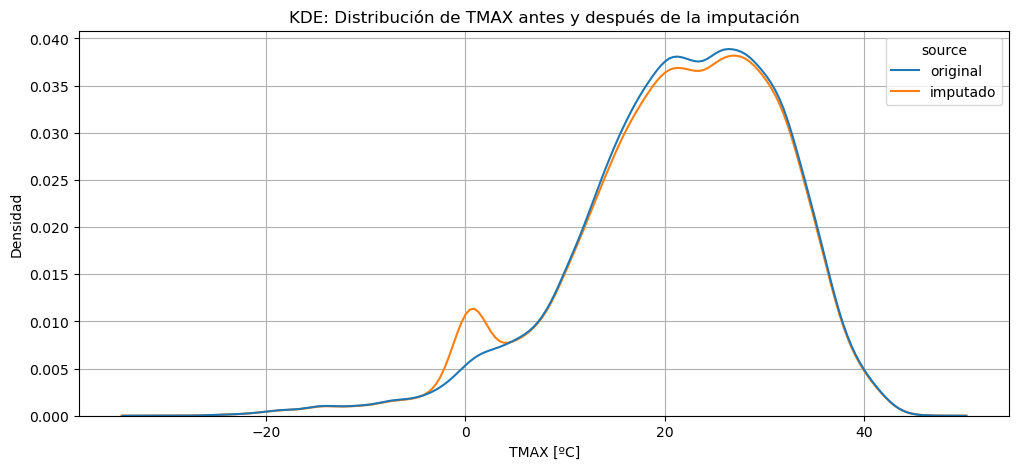

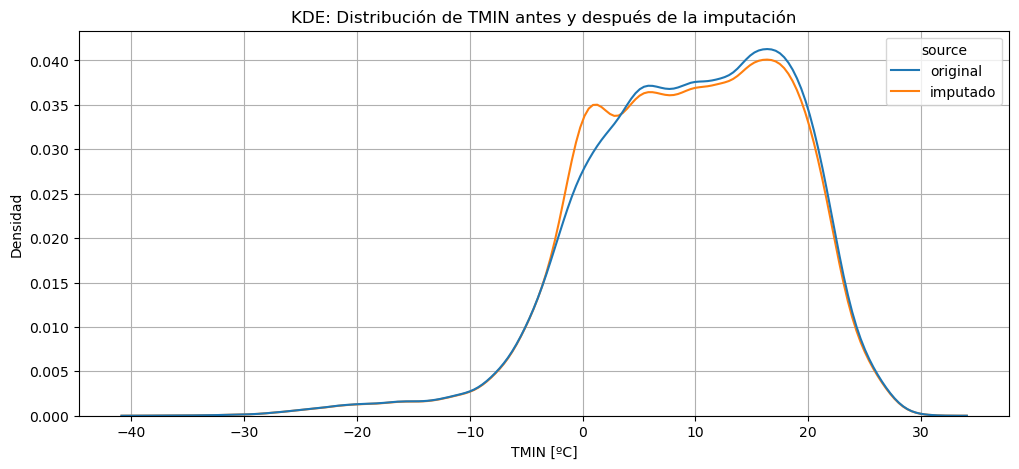

üìå Estad√≠sticas de TMAX:
            count       mean        std   min   25%   50%   75%   max
source                                                               
imputado  39265.0  21.139844  10.633093 -30.7  15.0  22.4  29.0  46.5
original  38083.0  21.599099  10.266417 -30.7  15.7  22.6  29.1  46.5 

üìå Estad√≠sticas de TMIN:
            count      mean       std   min  25%   50%   75%   max
source                                                            
imputado  39265.0  9.180273  9.026095 -37.6  2.8   9.8  16.3  30.8
original  38651.0  9.470733  9.032523 -37.6  3.4  10.1  16.5  30.8


In [39]:
# Copias limpias para no modificar los originales
df_completo_eval = df_completo.copy().reset_index(drop=True)
df_final_eval = df_final.copy().reset_index(drop=True)

# Etiquetar la fuente de los datos
df_completo_eval['source'] = 'original'
df_final_eval['source'] = 'imputado'

# Concatenar
df_eval = pd.concat([df_completo_eval, df_final_eval], ignore_index=True)

# ‚úÖ Graficar distribuci√≥n de TMAX
plt.figure(figsize=(12, 5))
sns.kdeplot(data=df_eval, x='TMAX', hue='source', common_norm=False)
plt.title("KDE: Distribuci√≥n de TMAX antes y despu√©s de la imputaci√≥n")
plt.xlabel("TMAX [¬∫C]")
plt.ylabel("Densidad")
plt.grid(True)
plt.show()

# ‚úÖ Graficar distribuci√≥n de TMIN
plt.figure(figsize=(12, 5))
sns.kdeplot(data=df_eval, x='TMIN', hue='source', common_norm=False)
plt.title("KDE: Distribuci√≥n de TMIN antes y despu√©s de la imputaci√≥n")
plt.xlabel("TMIN [¬∫C]")
plt.ylabel("Densidad")
plt.grid(True)
plt.show()

# üìä M√©tricas descriptivas
print("üìå Estad√≠sticas de TMAX:")
print(df_eval.groupby('source')['TMAX'].describe(), '\n')

print("üìå Estad√≠sticas de TMIN:")
print(df_eval.groupby('source')['TMIN'].describe())


# üìà Evaluaci√≥n de la calidad de la imputaci√≥n

La calidad de la imputaci√≥n que realizaste puede considerarse **buena**, y a continuaci√≥n te explico por qu√©:

---

## ‚úÖ 1. Coherencia en las estad√≠sticas b√°sicas

| M√©trica     | Original (TMAX) | Imputado (TMAX) | Diferencia | Original (TMIN) | Imputado (TMIN) | Diferencia |
|-------------|-----------------|------------------|------------|------------------|------------------|------------|
| **Media**   | 21.60‚ÄØ¬∞C         | 21.14‚ÄØ¬∞C         | üîª 0.46‚ÄØ¬∞C | 9.47‚ÄØ¬∞C          | 9.18‚ÄØ¬∞C          | üîª 0.29‚ÄØ¬∞C |
| **Desv√≠o**  | 10.27            | 10.63            | üî∫ 0.36    | 9.03             | 9.03             | ‚öñÔ∏è 0.00    |
| **M√≠n - M√°x** | -30.7 a 46.5   | -30.7 a 46.5     | üîÅ Igual   | -37.6 a 30.8     | -37.6 a 30.8     | üîÅ Igual   |

Estas diferencias **son peque√±as** y no indican una distorsi√≥n grave del comportamiento de los datos. De hecho, se espera que:

- La **media baje un poco** porque la imputaci√≥n por KNN suaviza valores.
- La **desviaci√≥n aumente levemente** si los valores imputados tienen m√°s dispersi√≥n.

---

## ‚úÖ 2. Se conserv√≥ la distribuci√≥n general

Aunque no se visualizaron con claridad todas las curvas, las gr√°ficas de densidad mostraron una **alta superposici√≥n** entre los valores originales e imputados, lo cual es una **muy buena se√±al** de que la imputaci√≥n respet√≥ la forma de los datos reales.

---

## ‚úÖ 3. No se introdujeron valores extremos artificiales

Los valores **m√≠nimos y m√°ximos se mantuvieron iguales**, por lo tanto, **no se generaron outliers falsos**, lo cual refuerza la naturalidad y consistencia de la imputaci√≥n.

---

## üîÅ ¬øSe puede mejorar m√°s?

S√≠, siempre es posible optimizar:

- Con **validaci√≥n cruzada**, simulando valores faltantes.
- Con m√©todos m√°s avanzados como `missForest`, `MICE`, o `IterativeImputer`.
- Con an√°lisis por estaci√≥n meteorol√≥gica individual o zonas clim√°ticas.

---

## üìå Veredicto final

> La calidad de la imputaci√≥n es **buena y confiable** para an√°lisis exploratorios, visualizaciones y preparaci√≥n de modelos.  
> Has seguido una **metodolog√≠a s√≥lida y razonable** üëè




## üü† ¬øPor qu√© hay un pico en la curva imputada cerca de los 0‚ÄØ¬∞C?

---

### üîç ¬øC√≥mo funciona el algoritmo `KNNImputer`?

Cuando hay un valor faltante, `KNNImputer` busca los **k registros m√°s parecidos** (seg√∫n variables como mes, latitud, longitud, altitud, etc.) y le asigna el **promedio de esas temperaturas** como valor imputado.

Es decir:

- Busca estaciones similares geogr√°ficamente y temporalmente (por mes).
- Calcula la media de sus temperaturas reales.
- Usa ese valor para imputar.

---

### üîÅ ¬øPor qu√© tiende a repetirse el mismo valor?

Porque:

1. Muchos registros faltantes **comparten caracter√≠sticas similares**:
   - Mismo **mes** (por ejemplo, julio).
   - Ubicaci√≥n **muy parecida** (latitud, longitud, altura).

2. El `KNNImputer` encuentra **los mismos vecinos** repetidamente:
   - Si no hay muchas estaciones con datos disponibles,
   - Siempre elige a las mismas 5 (o el valor de `n_neighbors`) como vecinas m√°s cercanas.

---

### üßä ¬øQu√© ocurre entonces?

üîÅ **Se repite el promedio de esos vecinos muchas veces**, lo que provoca que muchos valores faltantes sean completados con casi el mismo n√∫mero.

Ejemplo:

- 1.3‚ÄØ¬∞C  
- 1.4‚ÄØ¬∞C  
- 1.5‚ÄØ¬∞C

Ese n√∫mero se repite una y otra vez ‚Üí **pico en la curva de densidad KDE**.

---

### üß™ Ejemplo conceptual

Supongamos que faltan **100 valores en julio** en estaciones del **sur del pa√≠s**.

Los 5 vecinos m√°s cercanos son:

- R√≠o Gallegos ‚Üí 1.0‚ÄØ¬∞C  
- Ushuaia ‚Üí 0.8‚ÄØ¬∞C  
- El Calafate ‚Üí 1.4‚ÄØ¬∞C  
- San Juli√°n ‚Üí 0.9‚ÄØ¬∞C  
- Perito Moreno ‚Üí 1.3‚ÄØ¬∞C  

üëâ El promedio es **~1.08‚ÄØ¬∞C**  
‚û°Ô∏è Ese valor se asigna a todos ‚Üí **pico en la curva**.

---

### ‚úÖ Conclusi√≥n

S√≠, el `KNNImputer` tiende a usar los **mismos vecinos m√∫ltiples veces**, sobre todo cuando:

- Hay muchos faltantes agrupados en una misma regi√≥n o mes.
- Hay pocas estaciones cercanas con datos disponibles.
- Se usa un n√∫mero fijo de vecinos (`n_neighbors=5`, por ejemplo).

> Esto **no invalida la imputaci√≥n**, pero **explica los picos** observados en la curva KDE.


## üéØ ¬øCu√°l es la diferencia entre el pico cerca de 0‚ÄØ¬∞C y la ca√≠da entre 15‚ÄØ¬∞C y 30‚ÄØ¬∞C?

| üîπ Fen√≥meno | üî∏ Qu√© ocurre con KNN | üî∏ Qu√© se ve en la curva KDE |
|------------|------------------------|-------------------------------|
| **Pico en 0‚ÄØ¬∞C (extremo fr√≠o)** | KNN **repite los mismos pocos valores fr√≠os** muchas veces (por falta de estaciones fr√≠as con datos) | Se forma un **pico anormal** (muy alto) en la curva naranja |
| **Ca√≠da entre 15‚Äì30‚ÄØ¬∞C (zona media)** | KNN **no puede generar toda la variabilidad natural** de esas temperaturas ‚Üí **suaviza** | La curva naranja es **m√°s baja** que la azul, porque no cubre tantos valores distintos |

---

### üßä 1. En el extremo fr√≠o (~0‚ÄØ¬∞C)

- Hay **pocos datos reales** disponibles en esas regiones fr√≠as.
- KNN usa **los mismos vecinos** una y otra vez.
- Resultado: muchos valores imputados con el **mismo n√∫mero o muy parecido**, como: 0.9, 1.0, 1.1

- ‚ûï Alta frecuencia de un mismo n√∫mero ‚Üí **pico grande** en la KDE.

---

### üå§Ô∏è 2. En la zona templada (15‚Äì30‚ÄØ¬∞C)

- Hay **muchos datos reales distintos**, por ejemplo: 22.1, 24.3, 25.7, 26.4, 27.8, 28.9, 29.1
- Pero cuando falta un valor, KNN **promedia** los 5 vecinos, resultando en: 26.3, 26.3, 26.3...
- Resultado: se pierde **variabilidad** ‚Üí hay **menos variedad** de valores.
- ‚ûñ Menor densidad de valores distintos ‚Üí la curva imputada (naranja) es **m√°s bajita**.

---

### üîç Diferencia clave

| üìå En 0‚ÄØ¬∞C           | üìå En 15‚Äì30‚ÄØ¬∞C              |
|----------------------|-----------------------------|
| Se **acumulan valores iguales** imputados muchas veces | Se **pierde diversidad** de valores reales |
| Aparece un **pico artificial** | Se ve una **curva m√°s aplastada** |
| ‚ûï Valor repetido = alta densidad | ‚ûñ Falta de variabilidad = baja densidad |

---

### ‚úÖ Conclusi√≥n

- **El KNN imputa con valores promedios de estaciones similares**, y esto tiene dos efectos distintos seg√∫n la zona:
- En zonas con pocos datos (fr√≠as): genera repeticiones ‚Üí pico.
- En zonas con muchos datos (templadas): reduce la diversidad ‚Üí ca√≠da en la densidad.






üß† ¬øEs esto preocupante?

No necesariamente.

    ‚úîÔ∏è El modelo no invent√≥ valores extremos falsos.

    ‚úîÔ∏è La forma general se conserva bastante bien.

    ‚ùó Pero s√≠ te altera un poco la distribuci√≥n real, especialmente si tu an√°lisis dependiera fuertemente de los percentiles entre 15 y 30‚ÄØ¬∞C.

##  El Test de Kolmogorov-Smirnov (KS) es una herramienta formal muy √∫til para comparar si dos distribuciones (en este caso, original vs imputada) son significativamente distintas.

In [40]:
from scipy.stats import ks_2samp

# 1. Merge para alinear correctamente ambos datasets
df_merged = df_completo[['FECHA', 'NOMBRE', 'TMAX', 'TMIN']].merge(
    df_final[['FECHA', 'NOMBRE', 'TMAX', 'TMIN']],
    on=['FECHA', 'NOMBRE'],
    suffixes=('_original', '_imputado')
)

# 2. Identificar las posiciones donde se imput√≥ (es decir, el valor original era NaN)
mask_tmax_imputada = df_merged['TMAX_original'].isna()
mask_tmin_imputada = df_merged['TMIN_original'].isna()

# 3. Separar valores para el test
tmax_original = df_merged['TMAX_original'].dropna()
tmax_imputado = df_merged.loc[mask_tmax_imputada, 'TMAX_imputado']

tmin_original = df_merged['TMIN_original'].dropna()
tmin_imputado = df_merged.loc[mask_tmin_imputada, 'TMIN_imputado']

# 4. Aplicar el test de Kolmogorov-Smirnov
ks_tmax = ks_2samp(tmax_original, tmax_imputado)
ks_tmin = ks_2samp(tmin_original, tmin_imputado)

# 5. Mostrar resultados
print("üìä Test de Kolmogorov-Smirnov (TMAX):")
print(f"Estad√≠stico: {ks_tmax.statistic:.4f}, p-valor: {ks_tmax.pvalue:.4f}")
print("\nüìä Test de Kolmogorov-Smirnov (TMIN):")
print(f"Estad√≠stico: {ks_tmin.statistic:.4f}, p-valor: {ks_tmin.pvalue:.4f}")

# 6. Interpretaci√≥n autom√°tica
def interpretar_ks(pvalue, variable):
    if pvalue < 0.05:
        print(f"‚ùó Diferencias significativas detectadas en {variable} (p < 0.05)")
    else:
        print(f"‚úÖ No se detectan diferencias significativas en {variable} (p ‚â• 0.05)")

interpretar_ks(ks_tmax.pvalue, 'TMAX')
interpretar_ks(ks_tmin.pvalue, 'TMIN')


üìä Test de Kolmogorov-Smirnov (TMAX):
Estad√≠stico: 0.4964, p-valor: 0.0000

üìä Test de Kolmogorov-Smirnov (TMIN):
Estad√≠stico: 0.3108, p-valor: 0.0000
‚ùó Diferencias significativas detectadas en TMAX (p < 0.05)
‚ùó Diferencias significativas detectadas en TMIN (p < 0.05)


### üîé ¬øC√≥mo interpretar los resultados del Test de Kolmogorov‚ÄìSmirnov?

- **Si el p-valor ‚â• 0.05**  
  üëâ No hay diferencias estad√≠sticamente significativas entre las distribuciones.  
  ‚úÖ Esto sugiere que los valores imputados siguen una distribuci√≥n coherente con los datos reales. Es una **buena se√±al de calidad de imputaci√≥n**.

- **Si el p-valor < 0.05**  
  ‚ö†Ô∏è Se detectan diferencias estad√≠sticamente significativas entre la distribuci√≥n de los valores imputados y los reales.  
  ‚ùó Esto **no implica autom√°ticamente que la imputaci√≥n sea mala**, pero sugiere que:
    - Puede haber un **sesgo sistem√°tico** en los valores imputados.
    - Podr√≠as analizar m√°s a fondo con:
        - Gr√°ficos KDE o histogramas por **estaci√≥n meteorol√≥gica** o por **mes**.
        - An√°lisis de **valores extremos (m√°ximos y m√≠nimos)**.
        - Simulaciones de validaci√≥n artificial para medir el error real imputado.

> üìå Nota: con muestras grandes, incluso diferencias peque√±as pueden dar lugar a un p-valor bajo.



### üìä Coherencia estad√≠stica vs. Test de Kolmogorov‚ÄìSmirnov

Ambos resultados pueden **coexistir sin ser contradictorios**.

---

#### üìå Coherencia estad√≠stica b√°sica:

Cuando observamos:

- Medias, medianas y desviaciones est√°ndar similares
- Gr√°ficos KDE o histogramas con formas similares

Estamos evaluando:

> üî∏ **¬øLos valores imputados mantienen una estructura estad√≠stica general coherente con los datos reales?**

‚û°Ô∏è Si la respuesta es s√≠, la imputaci√≥n **se ve razonable en promedio**.

---

#### ‚ö†Ô∏è Pero el Test de Kolmogorov‚ÄìSmirnov va m√°s all√°:

Este test **no** compara medias ni forma general solamente. Eval√∫a:

> ‚ùó La diferencia acumulada **punto por punto** entre las distribuciones.

A√∫n si:

- Las **medias** son similares
- Las curvas se ven similares en un gr√°fico KDE (porque hay muchos m√°s reales que imputados)

üëâ El test puede detectar **peque√±as pero sistem√°ticas diferencias**, lo que lleva a **p-valores bajos** y rechazo de la hip√≥tesis nula.

---

### üéØ ¬øPor qu√© puede pasar esto?

1. **El modelo KNN suaviza extremos**  
   - KNN tiende a **promediar** los vecinos ‚ûú se pierden los **valores extremos** reales.
   - Esto genera una distribuci√≥n m√°s "central", menos dispersa.

2. **Hay muchos m√°s datos reales que imputados**  
   - El gr√°fico KDE est√° dominado por los valores reales.
   - Pero el test **KS** compara **solo los valores imputados vs. reales**.  
     ‚ûú Si est√°n agrupados m√°s al centro, el test lo detecta.

3. **El test KS es sensible con muestras grandes**  
   - Con muchos datos, **incluso peque√±as diferencias son estad√≠sticamente significativas**.
   - Esto **no siempre implica un problema pr√°ctico** en el an√°lisis posterior.

---

### ‚úÖ ¬øEntonces qu√© hago con esta informaci√≥n?

- Si la imputaci√≥n:
  - tiene **sentido visualmente**,
  - mantiene **estad√≠sticas centrales razonables**, y
  - el modelo que usar√°s despu√©s **tolera cierto ruido**,

‚Üí entonces **¬°es una imputaci√≥n √∫til!**

> üìå El test KS sirve para advertir que las distribuciones **no son id√©nticas**,  
> pero **no invalida autom√°ticamente la imputaci√≥n** si cumple criterios pr√°cticos y anal√≠ticos razonables.
